In [ ]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN=False
np.random.seed(0)

In [6]:
main_df[(main_df['dataset'] == 'agriVision')]['obs_kurt'].value_counts()

obs_kurt
421.84155      1
628.03000      1
1363.73070     1
2698.31760     1
2654.29520     1
              ..
18930.71300    1
19065.92400    1
8522.20500     1
6464.18550     1
6981.02830     1
Name: count, Length: 176, dtype: int64

In [39]:
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def convex_hull_intersection(hull1, hull2):
    if hull1 is None or hull2 is None:
        return 0
    poly1_coords = hull1.points[hull1.vertices]
    
    poly2_coords = hull2.points[hull2.vertices]
    poly1 = Polygon(poly1_coords)
    poly2 = Polygon(poly2_coords)
    inter_poly = poly1.intersection(poly2)

    if inter_poly.is_empty:
        return None
    if inter_poly.geom_type == 'Polygon':
        return ConvexHull(np.array(inter_poly.exterior.coords))
    elif inter_poly.geom_type == 'MultiPolygon':
        largest = max(inter_poly.geoms, key=lambda g: g.area)

        return ConvexHull(np.array(largest.exterior.coords))
    else:
        return np.nan

intersect_df = main_df[(~main_df['hull_kurt'].isna()) & (~main_df['hull'].isna())].copy()
intersect_df['hull_points'] = intersect_df['hull'].apply(lambda x : x.points[x.vertices])
intersect_df['hull_kurt_points'] = intersect_df['hull_kurt'].apply(lambda x : x.points[x.vertices])
intersect_df['hull_intersection'] = intersect_df.apply(
    lambda row: convex_hull_intersection(
        ConvexHull(row['hull_kurt_points']), 
        ConvexHull(row['hull_points'])
    ), axis=1)

main_df = main_df.merge(intersect_df[['hull_intersection']], left_index=True, right_index=True, how='left')#.drop(['hull_intersection_x'], axis=1)
main_df['hull_kurt_intersect_hull_area'] = main_df['hull_intersection'].apply(lambda x : x.volume if type(x) == ConvexHull else 0)
main_df

,group,dataset,subset,transform,orientation,channel,dataset_type,obs_var,var_lower,var_upper,...,kstest_pval_gengamma,github_plot,total_samples,beat_all_priors,best_prior,failure_category,failure_type,which_ones,hull_intersection,hull_kurt_intersect_hull_area
0,2,agriVision,full,fourier,NaN,blue,remote sensing,1292.946700,749.107670,2108.430700,...,1.808228e-02,https://github.com/yashdave003/hierarchical-ba...,45000.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
1,5,agriVision,full,fourier,NaN,blue,remote sensing,662.654400,382.089750,1248.617800,...,7.143833e-03,https://github.com/yashdave003/hierarchical-ba...,117000.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
2,8,agriVision,full,fourier,NaN,blue,remote sensing,256.633900,133.792040,650.845600,...,1.120706e-04,https://github.com/yashdave003/hierarchical-ba...,189000.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
3,11,agriVision,full,fourier,NaN,blue,remote sensing,121.961570,57.215298,390.192930,...,1.278194e-05,https://github.com/yashdave003/hierarchical-ba...,495000.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
4,14,agriVision,full,fourier,NaN,blue,remote sensing,48.468010,23.179575,151.679550,...,3.586150e-06,https://github.com/yashdave003/hierarchical-ba...,1134000.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,4,syntheticMRI3D,full,wavelet,ddd,NaN,medical,241418.060000,225806.880000,257381.550000,...,2.871511e-01,https://github.com/yashdave003/hierarchical-ba...,22538.0,1,GenGamma,actually_pass,pass,NaN,NaN,0.0
1151,5,syntheticMRI3D,full,wavelet,ddd,NaN,medical,33947.695000,31871.596000,36147.625000,...,8.425889e-01,https://github.com/yashdave003/hierarchical-ba...,296776.0,1,GenGamma,actually_pass,pass,NaN,NaN,0.0
1152,6,syntheticMRI3D,full,wavelet,ddd,NaN,medical,6416.669400,5792.756300,7090.980500,...,4.771315e-54,https://github.com/yashdave003/hierarchical-ba...,2880648.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0
1153,7,syntheticMRI3D,full,wavelet,ddd,NaN,medical,397.892600,357.501070,450.380680,...,5.369889e-182,https://github.com/yashdave003/hierarchical-ba...,25362406.0,1,GenGamma,practically_pass,pass,NaN,NaN,0.0


In [48]:
summary_df = main_df.groupby(['transform', 'dataset']).agg({'pass_kurt_intersect_hull' : 'mean', 
                                                            'pass_kurt_anywhere' : 'mean', 
                                                            'num_pass_kurt_intersect_hull' : 'mean', 
                                                            'num_pass_kurt_anywhere' : 'mean',
                                                            'hull_kurt_area' : 'mean', 
                                                            'hull_area' : 'mean',
                                                            'hull_kurt_intersect_hull_area' : 'mean'}).astype(float).round(3)
summary_df['total_hulls'] = main_df.groupby(['transform', 'dataset']).agg({'group' : 'size'}).rename({'group' : 'total_hulls'}, axis=1).astype(int).round(3)
summary_df

pass_kurt_intersect_hull  pass_kurt_anywhere  \
transform dataset                                                         
fourier   agriVision                          0.000               0.000   
          pastis                              0.023               0.409   
          spaceNet                            0.125               0.219   
learned   agriVision                          0.000               0.083   
          coco                                0.278               0.690   
          pastis                              0.114               0.600   
          segmentAnything                     0.406               0.875   
          spaceNet                            0.304               0.643   
          standardTesting                     0.130               0.574   
wavelet   agriVision                          0.028               0.056   
          coco                                0.089               0.401   
          pastis                              0.071               0.375   
          segmentAnything                     0.111               0.426   
          spaceNet                            0.031               0.234   
          standardTesting                     0.000               0.333   
          syntheticMRI2D                      0.016               0.175   
          syntheticMRI3D                      0.000               0.143   

                           num_pass_kurt_intersect_hull  \
transform dataset                                         
fourier   agriVision                              0.000   
          pastis                                 35.341   
          spaceNet                               13.594   
learned   agriVision                              0.000   
          coco                                  690.484   
          pastis                                  2.971   
          segmentAnything                       907.516   
          spaceNet                               10.857   
          standardTesting                         4.667   
wavelet   agriVision                              0.764   
          coco                                    2.094   
          pastis                                  4.589   
          segmentAnything                         9.898   
          spaceNet                                0.859   
          standardTesting                         0.000   
          syntheticMRI2D                          2.889   
          syntheticMRI3D                          0.000   

                           num_pass_kurt_anywhere  hull_kurt_area  hull_area  \
transform dataset                                                              
fourier   agriVision                        0.000           0.000      0.051   
          pastis                          211.500          10.127    109.399   
          spaceNet                        805.406          88.303      4.270   
learned   agriVision                        0.900           0.002      0.044   
          coco                           1840.913         225.116     16.448   
          pastis                          429.743          26.498      3.648   
          segmentAnything                2109.781         251.877     19.035   
          spaceNet                       2149.339         402.522      7.269   
          standardTesting                 507.074          18.276      1.901   
wavelet   agriVision                      211.250          50.998      0.081   
          coco                           1450.943         131.100     26.812   
          pastis                           73.036          13.837      9.001   
          segmentAnything                1302.231         142.632     25.042   
          spaceNet                        894.906          74.503    448.891   
          standardTesting                  34.208           1.918     48.620   
          syntheticMRI2D                  111.222          23.755      3.961   
          syntheticMRI3D               

<Axes: xlabel='group', ylabel='Count'>

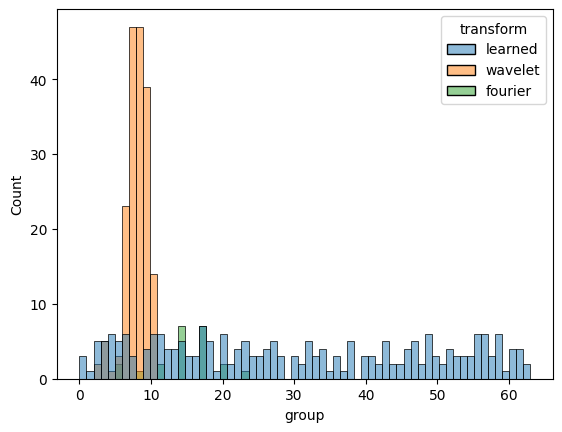

In [102]:
sns.histplot(data=intersect_df, x='group', hue='transform', bins=64)

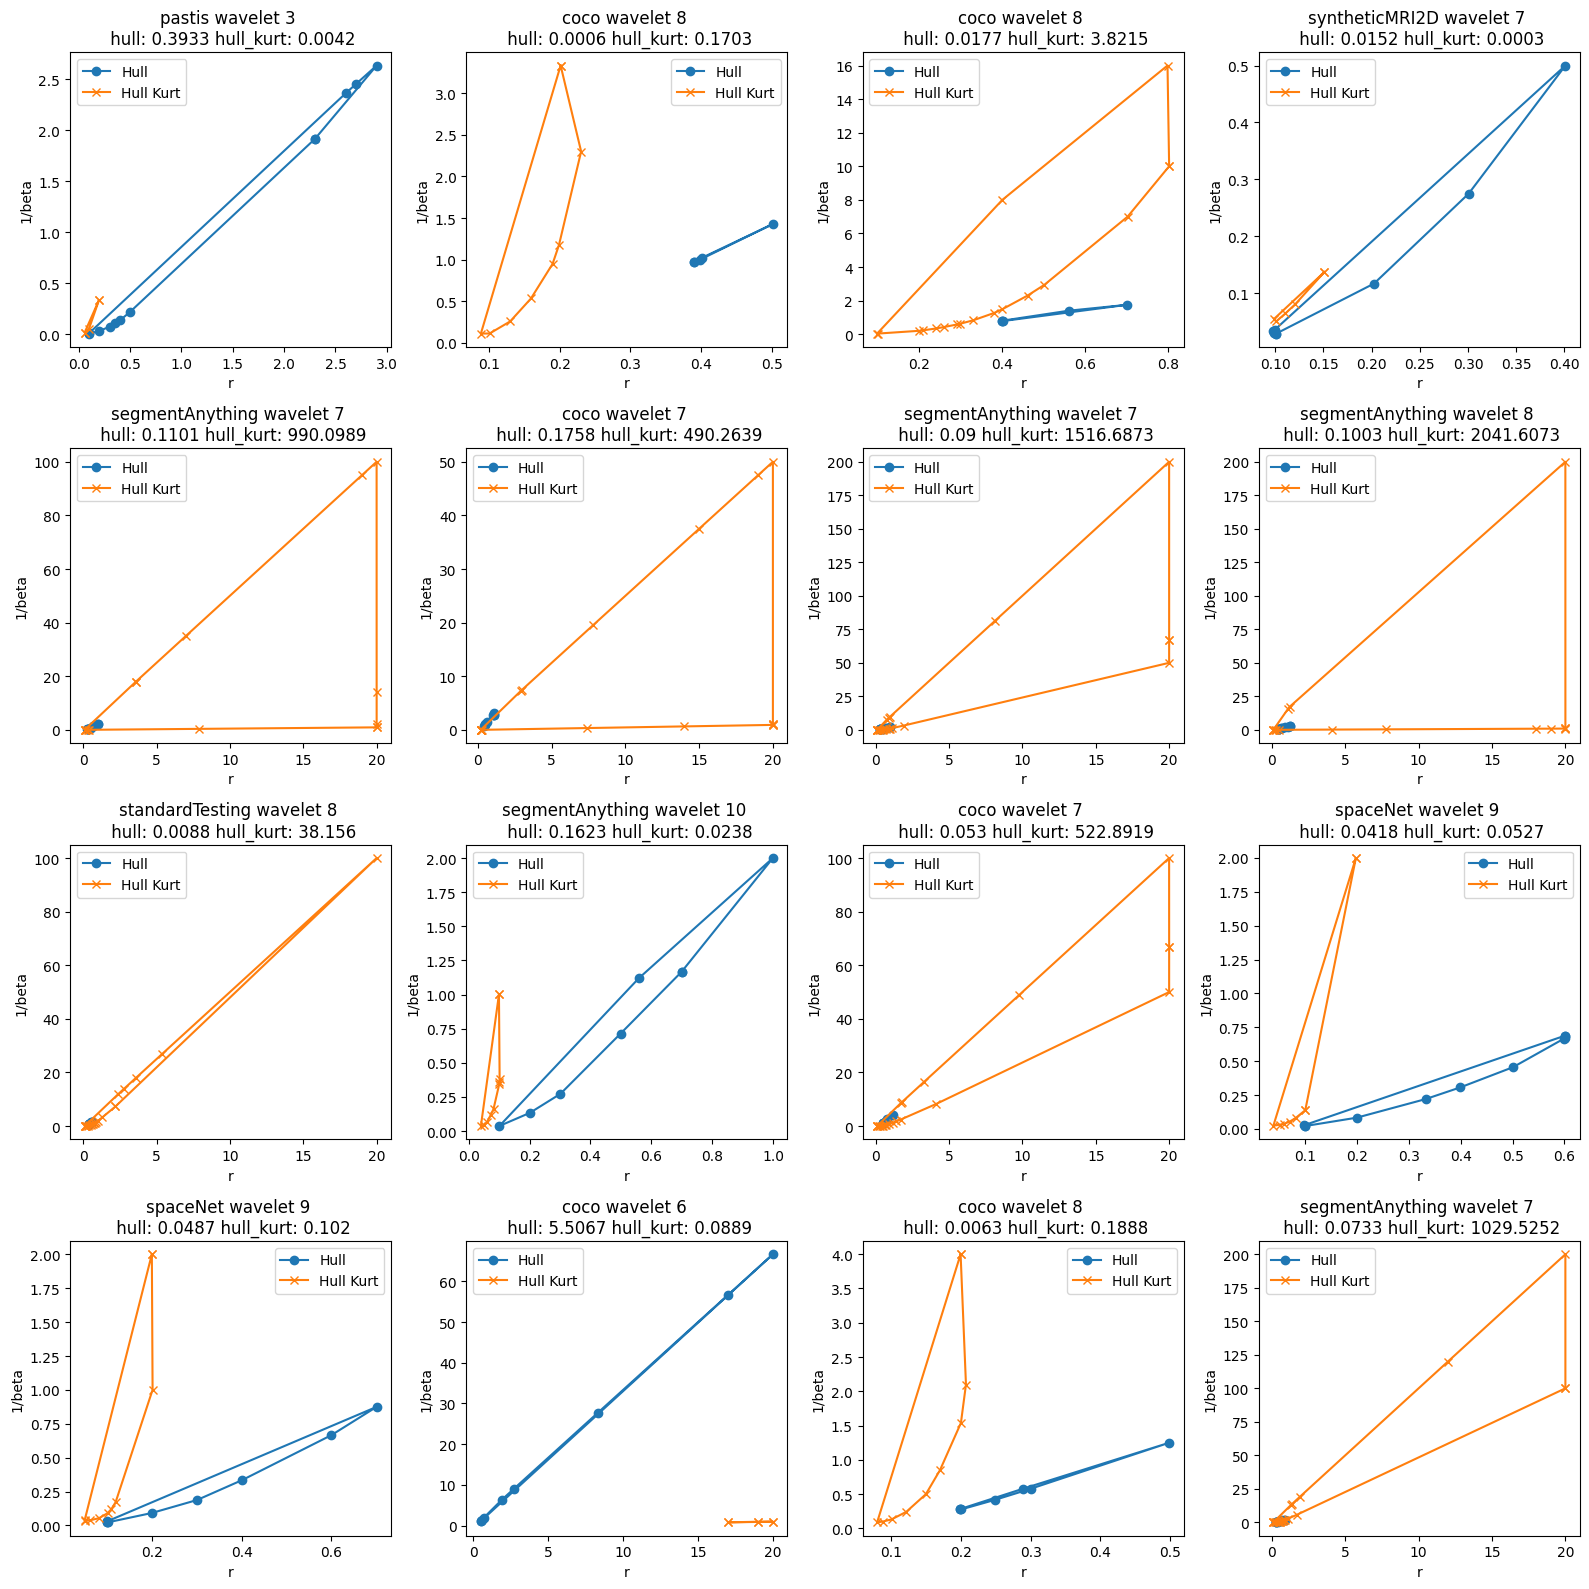

In [94]:
import random

import matplotlib.pyplot as plt

# Randomly select 25 rows from intersect_df
selected_rows = intersect_df[intersect_df['transform'] == 'wavelet'].sample(n=16, random_state=0)

# Create a 5x5 grid for subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Flatten the axes for easier iteration
axes = axes.flatten()

for i, (index, row) in enumerate(selected_rows.iterrows()):
    # Plot hull
    hull_points = row['hull_points']
    if hull_points is not None:
        closed_hull_points = list(hull_points) + [hull_points[0]]  # Close the hull
        axes[i].plot(*zip(*closed_hull_points), marker='o', label='Hull')
    
    # Plot hull_kurt
    hull_kurt_points = row['hull_kurt_points']
    if hull_kurt_points is not None:
        closed_hull_kurt_points = list(hull_kurt_points) + [hull_kurt_points[0]]  # Close the hull_kurt
        axes[i].plot(*zip(*closed_hull_kurt_points), marker='x', label='Hull Kurt')
    
    # Set titles and labels
    title = " ".join([selected_rows.loc[index, 'dataset'], selected_rows.loc[index, 'transform'], str(selected_rows.loc[index, 'group']), 
                      "\n hull:", str(selected_rows.loc[index, 'hull_area'].round(4)), "hull_kurt:", str(selected_rows.loc[index, 'hull_kurt_area'].round(4))])
    axes[i].set_title(title)#' '.join([selected_rows['dataset'], selected_rows['transform'], selected_rows['orientation']]))
    axes[i].set_xlabel('r')
    axes[i].set_ylabel('1/beta')
    axes[i].legend()

# Hide any unused subplots
for j in range(len(selected_rows), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [89]:
main_df['num_pass_kurt_anywhere'].value_counts()

num_pass_kurt_anywhere
0.0        687
5.0         12
3.0         12
2.0         11
15.0         8
          ... 
12752.0      1
11295.0      1
277.0        1
12644.0      1
584.0        1
Name: count, Length: 308, dtype: int64

In [43]:
fontsize = 15
markersize = 10
labelsize = 15
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
]

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

In [95]:
temp['kurt_map'].value_counts()

kurt_map
0.0    706
1.0    317
2.0    132
Name: count, dtype: int64

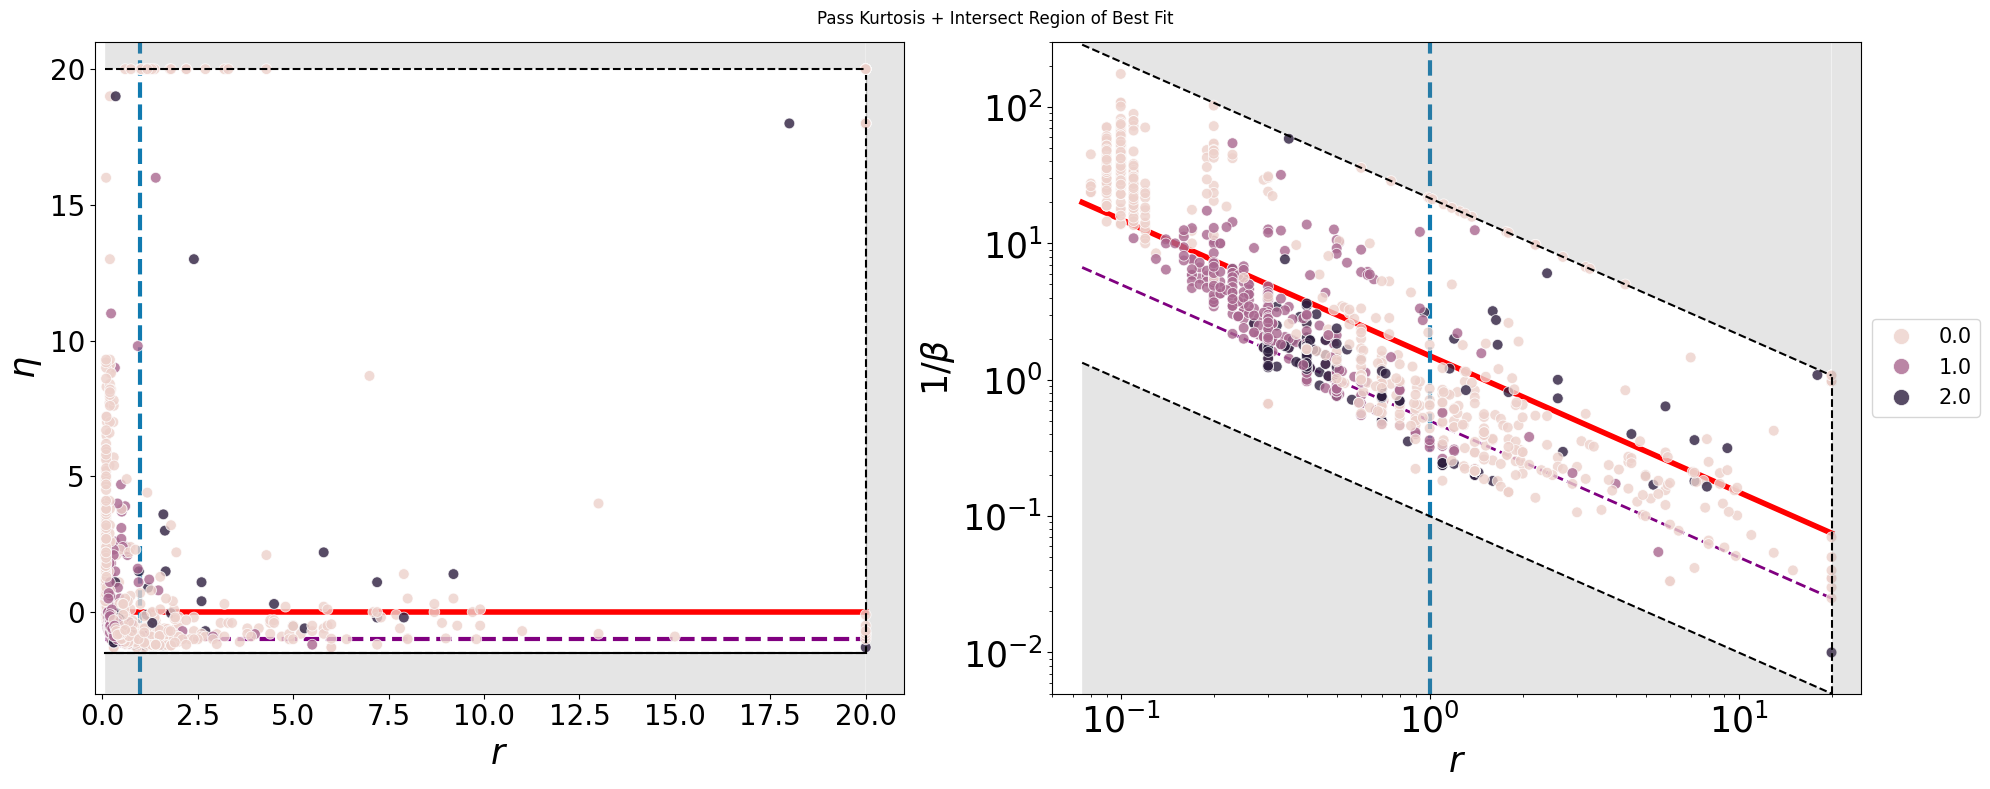

In [96]:
temp = main_df.copy()
temp['kurt_map'] = np.nan_to_num(temp['pass_kurt_anywhere'] + temp['pass_kurt_intersect_hull'])
temp['best_1/beta'] =  (temp['best_eta'] + 1.5) / temp['best_r']

fontsize=25
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20)
xlims = (r_valid[0] - 0.1, r_valid[1] + 0.1)
eta_lims = (-3, 21)
ylims = (eta_valid[0] - 0.1, eta_valid[1] + 0.1)

r_roi = (temp['best_r'].min() - 0.5, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = (1.5 + eta_valid[1]) / r_vals
beta_vals_below = (1.5 + (-1.4)) / r_vals

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
r_vals_roi = np.where(r_vals_roi == 0, 1e-10, r_vals_roi)  # Replace zero with a small positive value
beta_vals_roi_above = (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle("Pass Kurtosis + Intersect Region of Best Fit")

# First plot (left): r-eta space with failure categories
axes[0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[0].fill_between(r_vals, y1=eta_valid[1], y2 = 21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[0], linestyle='--')
axes[0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)

axes[0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0])
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0], linestyle="--")
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='kurt_map', ax=axes[0], alpha=0.8, s=60)

# axes[0].set_title(r'Best fit $r, \eta$ categorized by passing', fontsize=20)
axes[0].set_xlabel(r"$r$", fontsize=25)
axes[0].set_ylabel(r'$\eta$', fontsize=25)
axes[0].set_ylim(eta_lims)
axes[0].set_xlim((-0.2, 21))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# Second plot (right): r-(1/beta) space with failure categories
axes[1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1], linestyle="--")
axes[1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+100, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[1], linestyle='--', linewidth=2, zorder=0)
axes[1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_1/beta', hue='kurt_map', ax=axes[1], alpha=0.8, s=60)
axes[1].axvline(x=20.1, ymax=0.49, color='black', linestyle='dashed')
axes[1].fill_betweenx(y=[-1.4, 300], x1=20, x2=300, color='gray', alpha=0.2, ec=None)

# axes[1].set_title(r'Best fit $r, \beta$ categorized by passing', fontsize=20)
axes[1].set_xlabel(r"$r$", fontsize=fontsize)
axes[1].set_ylabel(r'$1/\beta$', fontsize=fontsize)
axes[1].set_xlim((0.06, 25))
axes[1].set_ylim((0.005, 300))
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
axes[1].legend(markerscale=1.5, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "kurtosis_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

ValueError: Could not interpret value `best_beta` for `y`. An entry with this name does not appear in `data`.

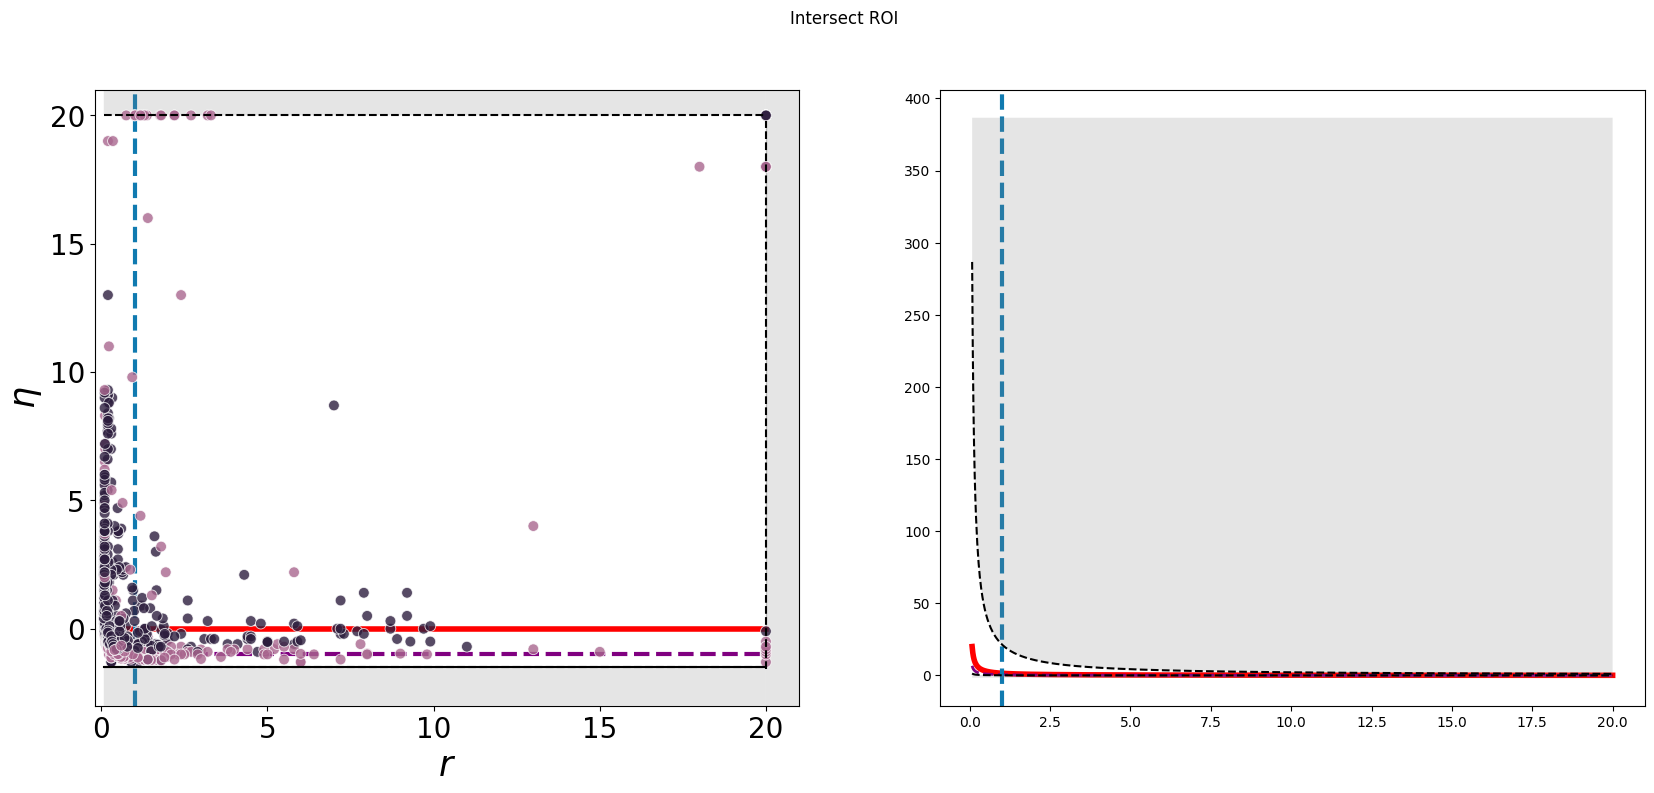

In [45]:
temp = main_df.copy()
fontsize=25
r_valid = (temp['best_r'].min() - 0.005, temp['best_r'].max())
eta_valid = (-1.5, 20)
xlims = (r_valid[0] - 0.1, r_valid[1] + 0.1)
eta_lims = (-3, 21)
ylims = (eta_valid[0] - 0.1, eta_valid[1] + 0.1)

r_roi = (temp['best_r'].min() - 0.5, temp['best_r'].max())
eta_roi = (-0.1, 0.1)
log_scale = True

r_vals = np.linspace(r_valid[0], r_valid[1], 1001)
beta_vals_above = (1.5 + eta_valid[1]) / r_vals
beta_vals_below = (1.5 + (-1.4)) / r_vals

r_vals_roi = np.linspace(r_roi[0], r_roi[1], 1001)
r_vals_roi = np.where(r_vals_roi == 0, 1e-10, r_vals_roi)  # Replace zero with a small positive value
beta_vals_roi_above = (3 / (2 * r_vals_roi) / 0.1)
beta_vals_roi_below = (3 / (2 * r_vals_roi) * (-0.1))

r_shade_roi = np.linspace(*r_roi, 100)
eta_shade_roi = np.linspace(*eta_roi, 100)

# Define Region of Interest borders in r-eta space
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate Region of Interest borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = beta_border

# Plot the Region of Interest in all 4 plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle("Intersect ROI")

# First plot (left): r-eta space with failure categories
axes[0].fill_between(r_vals, y1=eta_lims[0], y2=eta_valid[0], color='gray', alpha=0.2, ec=None)
axes[0].fill_between(r_vals, y1=eta_valid[1], y2 = 21, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=0, color='red', ax=axes[0], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=-1, color='purple', ax=axes[0], linestyle='--', linewidth=3, zorder=0)
sns.lineplot(x=[20, 20], y=[-1.5, 20], color='black', ax=axes[0], linestyle='--')
axes[0].axvline(x=20, ymin=0.06, ymax=0.95, color='black', linestyle='dashed')
axes[0].fill_betweenx(y=eta_lims, x1=20, x2=25, color='gray', alpha=0.2, ec=None)

axes[0].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', alpha=1, linewidth=3, zorder=0)
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0])
sns.lineplot(x=r_vals, y=eta_valid[0], color='black', ax=axes[0], linestyle="--")
sns.lineplot(x=r_vals, y=eta_valid[1], color='black', ax=axes[0], linestyle="--")
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='intersect_roi', ax=axes[0], alpha=0.8, s=60)

# axes[0].set_title(r'Best fit $r, \eta$ categorized by passing', fontsize=20)
axes[0].set_xlabel(r"$r$", fontsize=25)
axes[0].set_ylabel(r'$\eta$', fontsize=25)
axes[0].set_ylim(eta_lims)
axes[0].set_xlim((-0.2, 21))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].legend(markerscale=1.5, fontsize=10, loc='center right').set_visible(False)

# Second plot (right): r-(1/beta) space with failure categories
axes[1].fill_between(r_vals, ylims[0], beta_vals_below, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=beta_vals_above, color='black', ax=axes[1], linestyle="--")
sns.lineplot(x=r_vals, y=beta_vals_below, color='black', ax=axes[1], linestyle="--")
axes[1].fill_between(r_vals, y1=beta_vals_above, y2=beta_vals_above[0]+100, color='gray', alpha=0.2, ec=None)
sns.lineplot(x=r_vals, y=1.5 / r_vals, color='red', ax=axes[1], linewidth=4, zorder=0)
sns.lineplot(x=r_vals, y=(1.5 - 1) / r_vals, color='purple', ax=axes[1], linestyle='--', linewidth=2, zorder=0)
axes[1].axvline(x=1, color='xkcd:nice blue', linestyle='dashed', linewidth=3, alpha=1, zorder=0)
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='intersect_roi', ax=axes[1], alpha=0.5, s=60)
axes[1].axvline(x=20.1, ymax=0.49, color='black', linestyle='dashed')
axes[1].fill_betweenx(y=[-1.4, 300], x1=20, x2=300, color='gray', alpha=0.2, ec=None)

# axes[1].set_title(r'Best fit $r, \beta$ categorized by passing', fontsize=20)
axes[1].set_xlabel(r"$r$", fontsize=fontsize)
axes[1].set_ylabel(r'$\beta$', fontsize=fontsize)
axes[1].set_xlim((0.06, 25))
axes[1].set_ylim((0.005, 300))
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
if log_scale:
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
axes[1].legend(markerscale=1.5, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))#.set_visible(False)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "failure_type_best_r_eta_beta_panel_plot.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

In [ ]:
main_df['intersect_roi'].value_counts()

intersect_roi
1    1136
0       6
Name: count, dtype: int64

In [ ]:
# Extract labels and handles from the figure
handles, labels = axes[0].get_legend_handles_labels()
labels = [l.replace("_", " ") for l in labels]
handles = ['pass_kurt_intersect_hull', 'pass_kurt_outside_hull', 'none']

C:\Users\yashd\AppData\Local\Temp\ipykernel_15648\3073803862.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend_fig.legend(handles=handles, labels=labels, loc='center', ncol=6, fontsize=12)


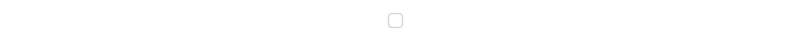

In [ ]:
desired_order = ['pass_kurt_intersect_hull', 'pass_kurt_outside_hull', 'none']
label_handle_map = dict(zip(labels, handles))

labels = [label for label in desired_order if label in label_handle_map]
handles = [label_handle_map[label] for label in labels]

legend_fig = plt.figure(figsize=(8, 0.5))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')  # Turn off the axis

legend_fig.legend(handles=handles, labels=labels, loc='center', ncol=6, fontsize=12)

plt.tight_layout()
plt.show()


if SAVE_FIGS:
    legend_save_path = os.path.join(plots_path, "failure_type_legend.jpg")
    legend_fig.savefig(legend_save_path, dpi=600, bbox_inches='tight')